# Packages and Configurations

In [31]:
import numpy as np

import hoomd
import gsd.hoomd

import matplotlib as mpl
import matplotlib.animation
from matplotlib import pyplot as plt

In [32]:
N_particles = 1000
radius = 0.5
sidenum = 4
name = "square"
disk_radius = 20 * radius
disk_origin = (0.0, 0.0)
seed = np.random.randint(np.iinfo(np.int16).max)
print(seed)

2645


In [33]:
seedless_file_suffix = f"{name}-{disk_radius/radius}-\
    ({disk_origin[0]},{disk_origin[1]})"
file_suffix = seedless_file_suffix + f"-{seed}"

# Plotting and Animation

In [34]:
def get_regpoly_patches(sidenum, radius, position, orientation, **kwargs):
    angle = 2 * np.arccos(orientation[:, 0]) * np.sign(orientation[:, 3])
    patches = [mpl.patches.RegularPolygon(position[i, :-1], sidenum, radius, angle[i])
               for i in range(len(position) - 1)]
    return mpl.collections.PatchCollection(patches, **kwargs)

def plot_snapshot(ax, snapshot, sidenum, radius, **kwargs):
    box = snapshot.configuration.box
    if "lw" not in kwargs:
        kwargs["lw"] = radius / max(box[0], box[1]) * 25

    ax.add_collection(get_regpoly_patches(
        sidenum, radius, snapshot.particles.position,
        snapshot.particles.orientation, **kwargs))

    ax.set_aspect("equal")
    box_x_extent = box[0] + box[3] * box[1]
    ax.set_xlim((-box_x_extent/2, box_x_extent/2))
    ax.set_ylim((-box[1]/2, box[1]/2))

    return ax

In [35]:
def animate_trajectory(traj, sidenum, radius, fps=15, **kwargs):
    fig, ax = plt.subplots()
    plot_snapshot(ax, traj[0], sidenum, radius, **kwargs)
    anim = mpl.animation.FuncAnimation(fig, animate_frame, frames=len(traj),
                                       blit=True, interval=1000/fps,
                                       fargs=(ax, ax.collections[0],
                                              traj, sidenum, radius))
    return anim

def animate_frame(frame, ax, patch_collection, traj, sidenum, radius):
    orientation = traj[frame].particles.orientation
    position = traj[frame].particles.position
    box = traj[frame].configuration.box

    angle = 2 * np.arccos(orientation[:, 0]) * np.sign(orientation[:, 3])
    patches = [mpl.patches.RegularPolygon(position[i, :-1], sidenum, radius, angle[i])
               for i in range(len(position))]
    patch_collection.set_paths(patches)

    box_x_extent = box[0] + box[3] * box[1]
    ax.set_xlim((-box_x_extent/2, box_x_extent/2))
    ax.set_ylim((-box[1]/2, box[1]/2))

    return patch_collection,

# Initial System Configuration

In [36]:
spacing = radius * 2.4
grid_dim = np.math.ceil((2 * N_particles)**0.5)
init_box_size = grid_dim * spacing

In [37]:
coordinates = np.mgrid[
    (-init_box_size/2 + spacing/2):(init_box_size/2 - spacing/2):complex(0, grid_dim),
    (-init_box_size/2 + spacing/2):(init_box_size/2 - spacing/2):complex(0, grid_dim)
]
lattice = np.column_stack((coordinates[0].flat, coordinates[1].flat))
pierced_lattice = lattice[
    np.linalg.norm(lattice - disk_origin, axis=1)
    >= disk_radius + radius
]

In [38]:
position = pierced_lattice[:N_particles]
position = np.hstack((position, np.zeros((N_particles, 1))))
position = np.concatenate((position, [disk_origin + (0,)]))
orientation = np.zeros((N_particles + 1, 4))
orientation[:, -1] = 1

In [39]:
snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = N_particles + 1
snapshot.particles.position = position
snapshot.particles.orientation = orientation
snapshot.particles.typeid = [0] * N_particles + [1]
snapshot.particles.types = [name, "disk"]
snapshot.configuration.box = [init_box_size, init_box_size, 0, 0, 0, 0]
with gsd.hoomd.open(f"data/lattice-{seedless_file_suffix}.gsd", mode="wb") as f:
    f.append(snapshot)

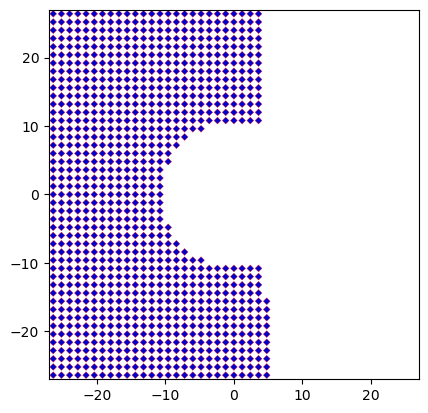

In [40]:
fig, ax = plt.subplots()
plot_snapshot(ax, snapshot, sidenum, radius,
              fc="mediumblue", ec="red")
plt.show()

# Simulation Initialization

In [41]:
sim = hoomd.Simulation(device=hoomd.device.CPU(), seed=seed)
sim.create_state_from_gsd(f"data/lattice-{seedless_file_suffix}.gsd")

## Polygon Integrator

In [42]:
def get_poly_vertices(sidenum, radius):
    angles = np.linspace(0, 2*np.pi, sidenum, endpoint=False)
    return np.column_stack((radius * np.cos(angles), radius * np.sin(angles)))

In [43]:
mc = hoomd.hpmc.integrate.ConvexPolygon(nselect=1)
mc.shape[name] = dict(vertices=get_poly_vertices(sidenum, radius))
mc.d[name] = radius / 2
mc.a[name] = np.pi / 8
sim.operations.integrator = mc

## Disk Block

In [44]:
mc.shape["disk"] = dict(vertices=get_poly_vertices(4000, disk_radius))
mc.d["disk"] = 0.0
mc.a["disk"] = 0.0

# Mixing to a Random Configuration

In [45]:
sim.run(10 * N_particles)

RuntimeError: Too many polygon vertices

In [ ]:
fig, ax = plt.subplots()
plot_snapshot(ax, sim.state.get_snapshot(), sidenum, radius,
              fc="mediumblue", ec="red")
plt.show()

In [ ]:
hoomd.write.GSD.write(
    sim.state, f"data/mixed-{file_suffix}.gsd", mode="wb")

# Compression to Critical Density

In [ ]:
V_particle = 0.5 * sidenum * radius**2 * np.math.sin(2*np.pi / sidenum)
initial_volume_fraction = (N_particles * V_particle
                           / (sim.state.box.volume - disk_radius**2))
print(initial_volume_fraction)

In [ ]:
final_box = hoomd.Box.from_box(sim.state.box)
final_volume_fraction = 0.8
final_box.volume = (N_particles * V_particle
                    / final_volume_fraction
                    + disk_radius**2)
compress = hoomd.hpmc.update.QuickCompress(
    trigger=hoomd.trigger.Periodic(10), target_box=final_box)
sim.operations.updaters.append(compress)

## Tuning the Acceptance Ratio

In [ ]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['a', 'd'], target=0.2, trigger=hoomd.trigger.Periodic(10),
    max_translation_move=radius/2, max_rotation_move=np.pi/8)
sim.operations.tuners.append(tune)

## Running the Compression

In [ ]:
sim.run(100 * N_particles)

In [ ]:
if not compress.complete:
    raise RuntimeError("Compression failed to complete")

In [ ]:
fig, ax = plt.subplots()
plot_snapshot(ax, sim.state.get_snapshot(), sidenum, radius,
              fc="mediumblue", ec="red")
plt.show()

In [ ]:
hoomd.write.GSD.write(
    sim.state, f"data/compressed-{file_suffix}.gsd", mode="wb")

# Equilibriating the System
## Tuning the Acceptance Ratio

In [ ]:
sim.operations.tuners.pop()
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['a', 'd'],
    target=0.2,
    trigger=hoomd.trigger.And([
        hoomd.trigger.Periodic(100),
        hoomd.trigger.Before(sim.timestep + 100 * N_particles)
    ]))
sim.operations.tuners.append(tune)

In [ ]:
sim.run(100 * N_particles)
sim.run(500)
translation_acceptance = mc.translate_moves[0] / sum(mc.translate_moves)
rotation_acceptance = mc.rotate_moves[0] / sum(mc.rotate_moves)
translation_acceptance, rotation_acceptance

## Adding State Recorder

In [ ]:
gsd_writer = hoomd.write.GSD(
    filename=f"data/trajectory-{file_suffix}.gsd", mode="wb",
    trigger=hoomd.trigger.Periodic(N_particles))
sim.operations.writers.append(gsd_writer)

## Running the Simulation

In [ ]:
sim.run(1000 * N_particles)

In [ ]:
fig, ax = plt.subplots()
plot_snapshot(ax, sim.state.get_snapshot(), sidenum, radius,
              fc="mediumblue", ec="red")
plt.show()

In [ ]:
traj = gsd.hoomd.open(f"data/trajectory-{file_suffix}.gsd")
anim = animate_trajectory(traj, sidenum, radius, fc="mediumblue", ec="red")
ffpmeg_writer = mpl.animation.FFMpegWriter(fps=15, extra_args=["-preset", "veryslow"])
anim.save(f"../../anim/disk-block-{file_suffix}.mp4")